In [1]:
# data processing
import pandas as pd
import numpy as np
import json

# modelling
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, auc, roc_curve, accuracy_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#x_train, x_val = train_test_split(train_images, test_size=0.2, random_state=42)

Dataset split: 60000 train rows
Dataset split: 10000 test rows


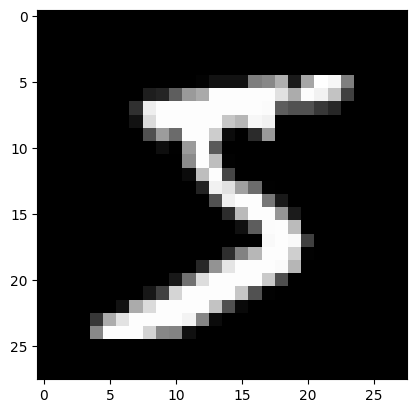

In [4]:
print(f"Dataset split: {len(train_images)} train rows")
print(f"Dataset split: {len(test_images)} test rows")

point = train_images[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [5]:
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


In [6]:
# normalize data
train_images = train_images.astype(np.float32) / 255
test_images = test_images.astype(np.float32) / 255

# reshape
train_images = train_images.reshape(-1, 784)
test_images = test_images.reshape(-1, 784)

In [8]:
print(train_images.shape)
print(test_images.shape)

(60000, 784)
(10000, 784)


In [9]:
latent_dim = 2

In [10]:
# encoder
vae_input = keras.layers.Input(shape=(784,))
x = keras.layers.Dense(256, activation='relu')(vae_input)
x = keras.layers.Dense(128, activation='relu')(x)
z_mean = keras.layers.Dense(latent_dim)(x)
z_log_var = keras.layers.Dense(latent_dim)(x)

In [11]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [12]:
z = keras.layers.Lambda(lambda x: sampling(x))([z_mean, z_log_var])

In [13]:
# decoder
decoder_input = keras.layers.Input(shape=(latent_dim,))
x = keras.layers.Dense(128, activation='relu')(decoder_input)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(784, activation='sigmoid')(x)
decoded = x

In [14]:
# Encoder model
encoder = keras.models.Model(inputs=vae_input, outputs=[z_mean, z_log_var, z])

# Decoder model
decoder = keras.models.Model(inputs=decoder_input, outputs=decoded)

In [15]:
vae_output = decoder(encoder(vae_input)[2])
vae = keras.models.Model(inputs=vae_input, outputs=vae_output)

In [16]:
def vae_loss(x, x_decoded_mean):
    reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded_mean))
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = -0.5 * tf.reduce_mean(kl_loss, axis=-1)
    vae_loss = reconstruction_loss + kl_loss
    return vae_loss

vae.add_loss(vae_loss(vae_input, vae_output))

In [17]:
vae.compile(optimizer='adam')

In [18]:
vae.fit(train_images, train_images, epochs=20, batch_size=64, validation_data=(test_images, test_images))

Epoch 1/20
938/938 [==============================] - 5s 4ms/step - loss: 0.0715 - val_loss: 0.0676
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0674 - val_loss: 0.0676
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0674 - val_loss: 0.0676
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0674 - val_loss: 0.0676
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 8/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 9/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 10/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0673 - val_loss: 0.0675

In [19]:
decoded_images = vae.predict(test_images)

# calculate the reconstruction error for each sample
reconstruction_errors = np.mean(np.square(test_images - decoded_images), axis=1)

313/313 [==============================] - 1s 1ms/step


In [20]:
# define a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies based on the threshold
anomaly_indexes = np.where(reconstruction_errors > threshold)[0]

In [21]:
# Get all the anomalies from the test_images
anomalies = test_images[anomaly_indexes]

# Create binary labels where 1 represents anomalies and 0 represents non-anomalies
anomaly_labels = np.where(reconstruction_errors > threshold, 1, 0)

In [22]:
print(len(anomalies))

500


In [24]:
# Get anomaly labels
label_of_anomalies = test_labels[anomaly_indexes]

# create a dict of indexes and labels
anomaly_dict = dict(zip(map(int, anomaly_indexes), label_of_anomalies))

In [25]:
anomaly_dict_serializable = {int(key): str(value) for key, value in anomaly_dict.items()}

In [26]:
# write to json file
json_filename = "anomalies.json"
with open(json_filename, 'w') as json_file:
    json.dump(anomaly_dict_serializable, json_file)

print(f"Anomaly dictionary saved to {json_filename}")

Anomaly dictionary saved to anomalies.json


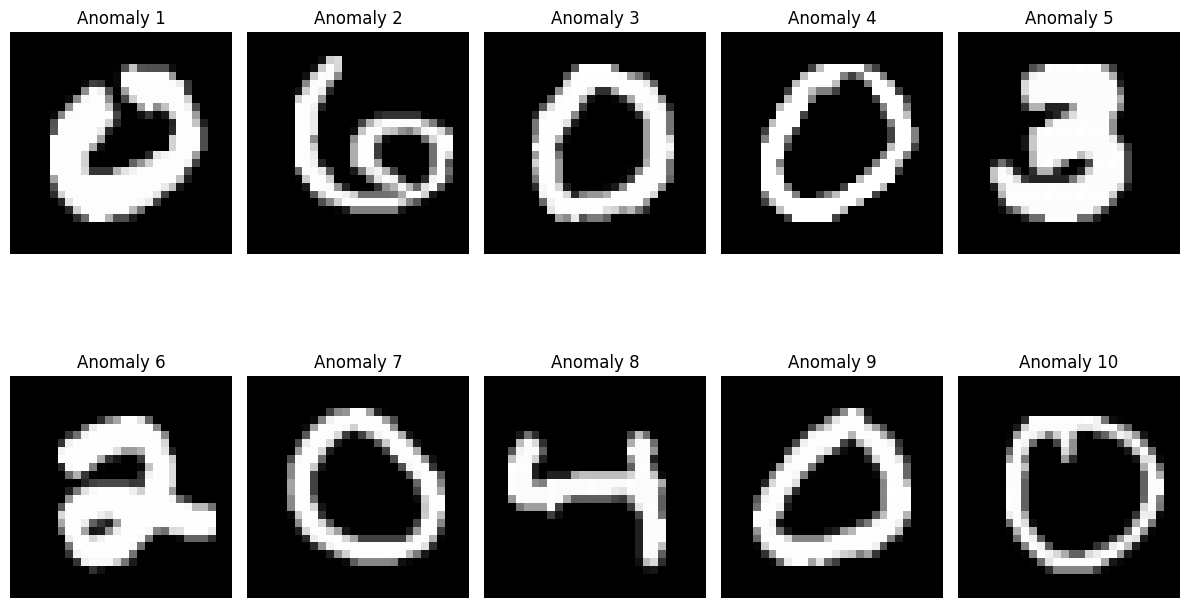

In [27]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomalies
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

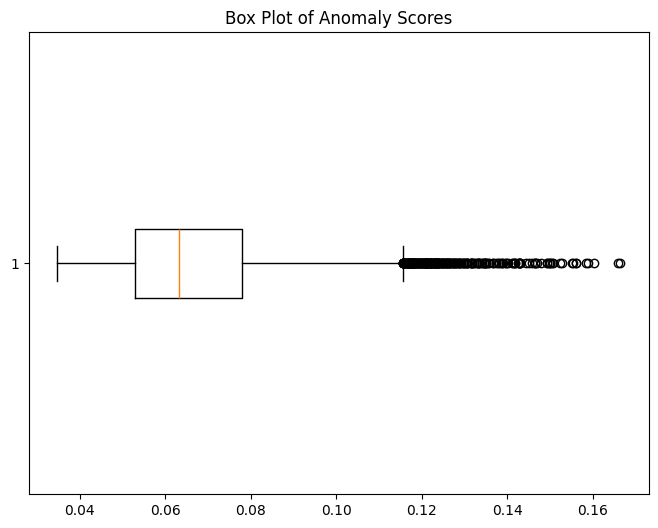

In [28]:
plt.figure(figsize=(8, 6))
plt.boxplot(reconstruction_errors, vert=False)
plt.title('Box Plot of Anomaly Scores')
plt.show()

In [29]:
# calculate the true positve rate and false positive rate for different threshold levels
y_true = [1 if i in anomalies else 0 for i in range(len(test_images))]

# calculate the precision, recall, and f1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, anomaly_labels)

# print precision, recall, and f1 score
print(f'Precision: {precision[1]:.2f}')
print(f'Recall: {recall[1]:.2f}')
print(f'F1 Score: {f1[1]:.2f}')

Precision: 0.00
Recall: 0.00
F1 Score: 0.00


In [30]:
# calculate the precision and recall for different threshold levels
precision, recall, thresholds = precision_recall_curve(y_true, reconstruction_errors)

# calculate the area under the precision-recall curve
pr_auc = auc(recall, precision)

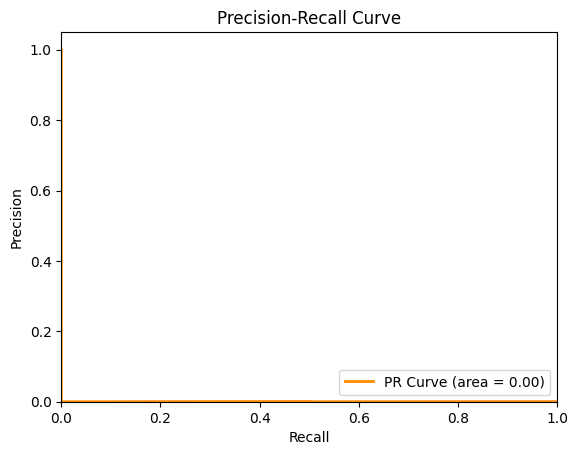

In [31]:
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR Curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

In [32]:
# create binary labels for anomalies and generate a classification report
# binary labels where 1 represents anomalies and 0 represents non-anomalies
anomaly_labels = np.where(reconstruction_errors > threshold, 1, 0)
report = classification_report(y_true, anomaly_labels)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      9998
           1       0.00      0.00      0.00         2

    accuracy                           0.95     10000
   macro avg       0.50      0.47      0.49     10000
weighted avg       1.00      0.95      0.97     10000

